# Non-Stationary Problem

Los métodos de average vistos en la notebook 2_2_to_2_3_action_value_methods.ipynb no son adecuados para problemas no estacionarios.

En esta notebook vamos a simular que las máquinas cambian a lo largo del tiempo

## Idea:

Vamos a darle más importancia a los rewards que ocurren más recientemente respecto a los que ocurrieron en el pasado.

Para hacer esto si pensamos en la regla de actualización de $Q$ que vimos antes que se puede escribr como:

$$Q_{k+1} = Q_k + \alpha (R_k - Q_k)$$

Con $\alpha = \frac{1}{k}$.

Podemos hacer que $\alpha$ sea ahora un valor constante entre 0 y 1.

De esta manera, en el libro se muestra que esta regla se puede reescribir como:

$$Q_{k+1} = (1 - \alpha) Q_1 + \sum_{i=1}^{k} \alpha (1 - \alpha)^{k-i} R_i$$

Por lo que esta regla está dando más peso a los rewards más recientes.

## Non-Stationary N-armed Band

Vamos a comparar el método de average con el método de average ponderado en un problema no estacionario.

Para esto vamos a simular un problema de 10-armed bandit no estacionario, donde las recompensas de cada acción siguen una distribución normal con media 0 y desviación estándar 1 pero cada 100 steps dentro de una task las recompensas de las acciones se mezclan al azar.

Por lo tanto, la mejor acción cambia a lo largo del tiempo.


A continuación ejecutamos una sola task para cada agente.

In [1]:
from tabular_solutions import armed_bandit
import numpy as np

In [2]:
n = 5
mean_rewards = np.zeros(n)
std_rewards = np.ones(n)
rewards = np.random.normal(mean_rewards, std_rewards, n)
noise = 1

env = armed_bandit.NArmedBanditNonStationary(
    n,
    rewards=rewards,
    noise=noise
)
agent = armed_bandit.IncrementalAgent(env, epsilon=0.1)

steps = 2000
agent.task(steps)
total_return = sum(agent.rewards)
avg_return = np.mean(agent.rewards)

print(f"Total return: {total_return:.2f}")
print(f"Average return: {avg_return:.6f}")

Total return: 1102.18
Average return: 0.551091


In [3]:
n = 5
mean_rewards = np.zeros(n)
std_rewards = np.ones(n)
rewards = np.random.normal(mean_rewards, std_rewards, n)
noise = 1

env = armed_bandit.NArmedBanditNonStationary(
    n,
    rewards=rewards,
    noise=noise
)
agent = armed_bandit.NonStationaryIncrementalAgent(env, epsilon=0.1, alpha=0.9)

steps = 2000
agent.task(steps)
total_return = sum(agent.rewards)
avg_return = np.mean(agent.rewards)

print(f"Total return: {total_return:.2f}")
print(f"Average return: {avg_return:.6f}")

Total return: 2322.39
Average return: 1.161195


## Experimento

Ahora ejecutaremos 2000 tasks de 1000 steps cada una y promediaremos los resultados para cada agente.

In [4]:
import time

def execute_task(agent_class, env_class, agent_eps=0, agent_q1=0):
    n = 10
    mean_rewards = np.zeros(n)
    std_rewards = np.ones(n)
    rewards = np.random.normal(mean_rewards, std_rewards)
    noise = 1

    env = env_class(
        n,
        rewards=rewards,
        noise=noise,
        steps_to_change=100
    )
    agent = agent_class(env, epsilon=agent_eps, initial_q_values=agent_q1)

    rewards_by_step = np.zeros(steps)
    optimal_action_chosen_by_step = np.zeros(steps)

    for step in range(steps):
        optimal_action = np.argmax(env.rewards)
        agent.task(1)
        rewards_by_step[step] = agent.rewards[-1]
        optimal_action_chosen_by_step[step] = env.last_action == optimal_action

    return rewards_by_step, optimal_action_chosen_by_step


def n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        agent_class=armed_bandit.Agent,
        env_class=armed_bandit.NArmedBanditNonStationary,
        agent_q1=0,
    ):

    agents_avg_reward_by_step = []
    agent_optimal_action_chosen_by_step = []
    start_time = time.time()
    for agent_eps in agents_epsilons:
        sum_rewards_by_step = np.zeros(steps)
        qty_action_chosen_by_step = np.zeros(steps)
        for _ in range(tasks_qty):
            rewards_by_step, optimal_action_chosen_by_step = execute_task(agent_class, env_class, agent_eps=agent_eps, agent_q1=agent_q1)
            sum_rewards_by_step += rewards_by_step
            qty_action_chosen_by_step += optimal_action_chosen_by_step
        agents_avg_reward_by_step.append(sum_rewards_by_step / tasks_qty)
        agent_optimal_action_chosen_by_step.append(qty_action_chosen_by_step / tasks_qty)
    end_time = time.time()
    print(f'Experiment took {(end_time - start_time) / 60:.2f} minutes')
    return agents_avg_reward_by_step, agent_optimal_action_chosen_by_step



### Agente método de average ($\alpha = \frac{1}{k}$)

Está pensado para problemas estacionarios, por lo que esperamos que no se adapte a los cambios en la tarea.

In [5]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

agents_avg_reward_by_step, agent_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons, steps, tasks_qty, agent_class=armed_bandit.IncrementalAgent
    )
)

Experiment took 1.11 minutes


### Agente método de average ponderado ($\alpha = 0.9$)


Este agente debería adaptarse a los cambios en la tarea.

In [6]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

non_stationary_agents_avg_reward_by_step, non_stationary_agent_optimal_action_chosen_by_step = n_armed_bandit_experiment(
    agents_epsilons, steps, tasks_qty, agent_class=armed_bandit.NonStationaryIncrementalAgent
    )

Experiment took 1.15 minutes


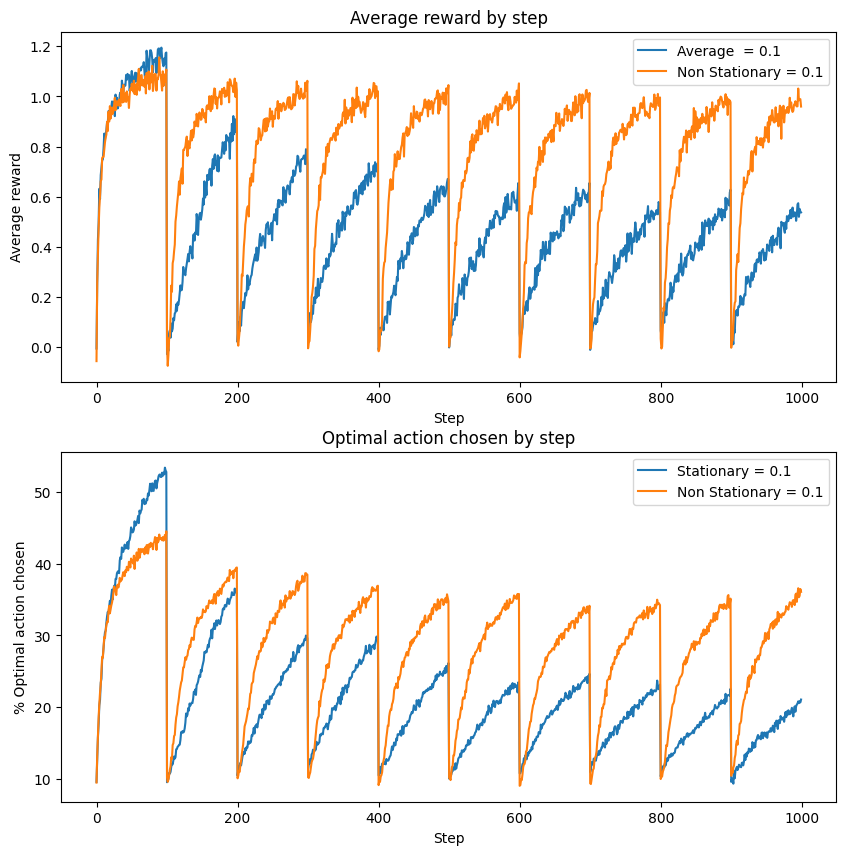

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(agents_avg_reward_by_step[0], label=f'Average  = {0.1}')
ax[0].plot(non_stationary_agents_avg_reward_by_step[0], label=f'Non Stationary = {0.1}')

ax[1].plot(agent_optimal_action_chosen_by_step[0] * 100, label=f'Stationary = {0.1}')
ax[1].plot(non_stationary_agent_optimal_action_chosen_by_step[0] * 100, label=f'Non Stationary = {0.1}')


ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

## Resultados

El algoritmo con $\alpha = 0.9$ es capaz de adaptarse a los cambios en las recompensas de las máquinas rápidamente mientras que el algoritmo que usa el promedio de los rewards ($\alpha = \frac{1}{k}$) no llega a adaptarse a los cambios de las máquinas antes de que vuelvan a cambiar.

# Optimistical values

Los métodos que vimos hasta ahora dependen en mayor o menor medida del valor inicial de $Q$. Esto se conoce como sesgo (bias).

El método de sample-average elimina el sesgo una vez que se visitan todas las acciones por lo menos una vez.

Sin embargo, el método de average ponderado no elimina el sesgo. Esto se puede ver en la propia fórmula de actualización de $Q$ donde el valor inicial de $Q$ tiene un peso de $(1 - \alpha)$ para todo $k$.

$$Q_{k+1} = (1 - \alpha) Q_1 + \sum_{i=1}^{k} \alpha (1 - \alpha)^{k-i} R_i$$

Sin embargo este sesgo decrece con el tiempo y no representa un problema real en la práctica, incluso es algo deseable en algunos casos.

Habiendo identificado esto, el valor inicial de $Q$ resulta ser un parámetro que podemos ajustar para obtener mejores resultados.

Por ejemplo si seteamos el valor de $Q$ en 5, sabiendo que las recompensas siguen una distribución normal con media 0, estamos siendo optimistas con el valor inicial. De esta manera vamos a estar incentivando la exploración de las accions ya que los rewards serán "decepcionantes" para el agente al principio.

El resultado será que el agente va a ejecutar varias veces todas las acciones hasta converger, incluso si la elección de la acción es greedy.

## Experimento

Ejecutemos un N armed bandit estacionario donde comparamos a un agente cuyo $Q_1=5$ para cada acción y su estrategia de elección es greedy contra otro agente que arranque con los valores de las acciones en 0, igual que la media de los rewards de cada máquina y que haga $\epsilon$-greedy con $\epsilon=0.1$

Ambos agentes calculan el valor de $Q$ con el método de average ponderado con $\alpha=0.1$

In [8]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

realistic_avg_reward_by_step, realistic_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        agent_class=armed_bandit.NonStationaryIncrementalAgent,
        env_class=armed_bandit.NArmedBandit,
        agent_q1=0,
    )
)

Experiment took 1.27 minutes


In [9]:
agents_epsilons = [0.0]
steps = 1000
tasks_qty = 2000

(
    optimistic_greedy_avg_reward_by_step,
    optimistic_greedy_optimal_action_chosen_by_step,
) = n_armed_bandit_experiment(
    agents_epsilons,
    steps,
    tasks_qty,
    agent_class=armed_bandit.NonStationaryIncrementalAgent,
    env_class=armed_bandit.NArmedBandit,
    agent_q1=5,
)

Experiment took 1.25 minutes


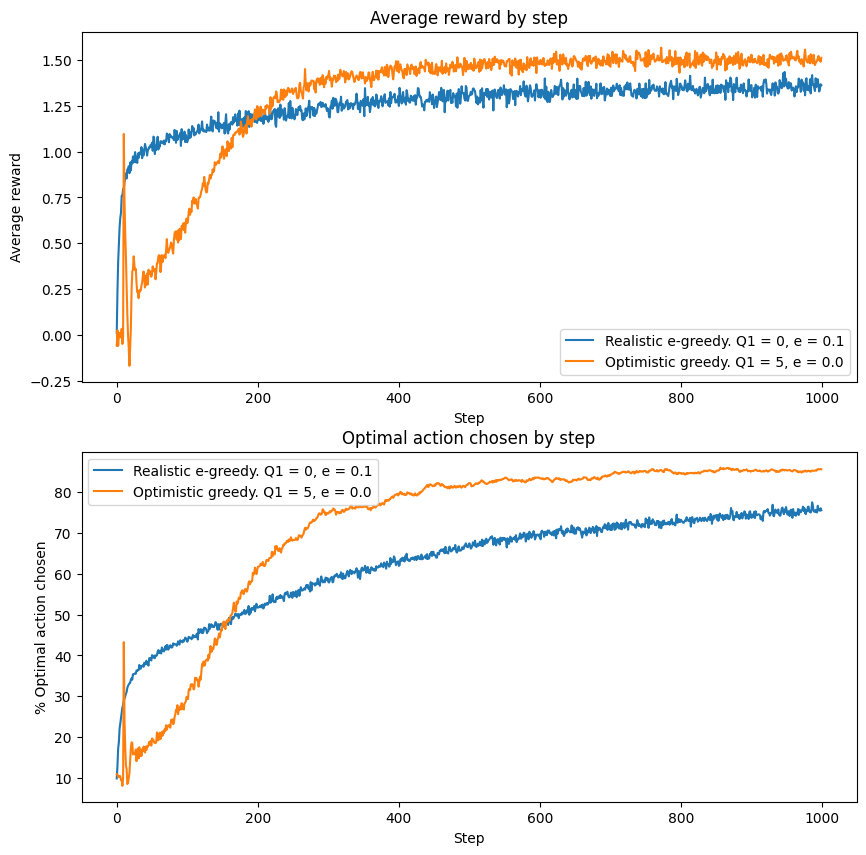

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(realistic_avg_reward_by_step[0], label=f'Realistic e-greedy. Q1 = {0}, e = {0.1}')
ax[0].plot(optimistic_greedy_avg_reward_by_step[0], label=f'Optimistic greedy. Q1 = {5}, e = {0.0}')

ax[1].plot(realistic_optimal_action_chosen_by_step[0] * 100, label=f'Realistic e-greedy. Q1 = {0}, e = {0.1}')
ax[1].plot(optimistic_greedy_optimal_action_chosen_by_step[0] * 100, label=f'Optimistic greedy. Q1 = {5}, e = {0.0}')


ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

# Resultados

El agente que arranca con $Q_1=5$ consigue encontrar la mejor acción mucho más rápido que el agente que arranca con $Q_1=0$.

Esto es debido a que el agente que arranca con $Q_1=5$ va a explorar más las acciones al principio y va a converger más rápido a la mejor acción.

## Experimento extra

Veamos qué pasa si hacemos el mismo experimento que antes pero ahora ambos agentes calculan el valor de $Q$ con el método de sample-average, es decir con $\alpha=\frac{1}{k}$.

In [11]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

realistic_avg_reward_by_step, realistic_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        agent_class=armed_bandit.IncrementalAgent,
        env_class=armed_bandit.NArmedBandit,
        agent_q1=0,
    )
)

Experiment took 1.05 minutes


In [12]:
agents_epsilons = [0.0]
steps = 1000
tasks_qty = 2000

(
    optimistic_greedy_avg_reward_by_step,
    optimistic_greedy_optimal_action_chosen_by_step,
) = n_armed_bandit_experiment(
    agents_epsilons,
    steps,
    tasks_qty,
    agent_class=armed_bandit.IncrementalAgent,
    env_class=armed_bandit.NArmedBandit,
    agent_q1=5,
)

Experiment took 1.10 minutes


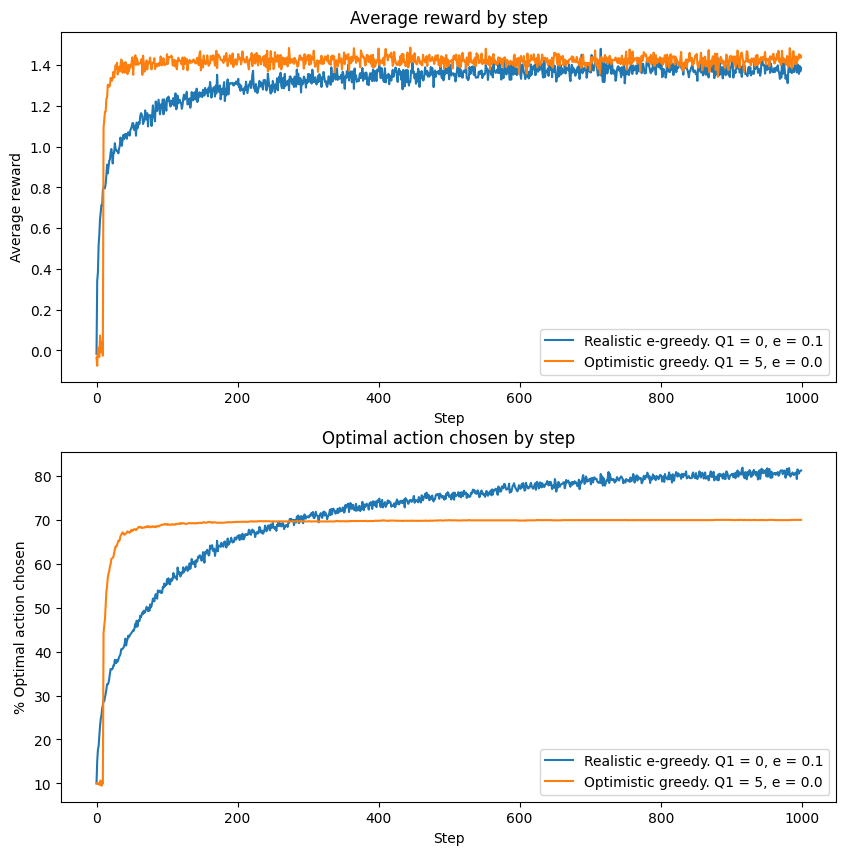

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(realistic_avg_reward_by_step[0], label=f'Realistic e-greedy. Q1 = {0}, e = {0.1}')
ax[0].plot(optimistic_greedy_avg_reward_by_step[0], label=f'Optimistic greedy. Q1 = {5}, e = {0.0}')

ax[1].plot(realistic_optimal_action_chosen_by_step[0] * 100, label=f'Realistic e-greedy. Q1 = {0}, e = {0.1}')
ax[1].plot(optimistic_greedy_optimal_action_chosen_by_step[0] * 100, label=f'Optimistic greedy. Q1 = {5}, e = {0.0}')


ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

## Conclusiones

A diferencia del experimento 1 donde usamos método de average ponderado, en este caso el agente greedy no consigue superar el 70% de eleccion de la mejor acción, mientras que en el experimento 1 el agente greedy con $Q_1=5$ supera el 80% superando en tasks de 1000 steps al agente $\epsilon$-greedy.